# 第5章 大規模言語モデルのファインチューニング

## 5.4 自然言語推論・意味的類似度計算・多肢選択式質問応答モデルの実装

### 5.4.2 意味的類似度計算

In [ ]:
!pip install datasets transformers[ja,torch] matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 75.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 23.8 MB/s eta 0:0

#### モデルの予測結果の取得

In [ ]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-jsts"
text_sim_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-jsts",
    function_to_apply="none",  # 出力に適用する関数の指定
    device="cuda:0"
)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset jglue downloaded and prepared to /root/.cache/huggingface/datasets/llm-book___jglue/JSTS/1.1.0/afed02e914319785e72f3ea981b4bd3e00089f2361b1137820c183c6b8173edd. Subsequent calls will reuse this data.


In [ ]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = text_sim_pipeline({"text": example["sentence1"], "text_pair": example["sentence2"]})

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_score": model_prediction["score"],
            "true_score": example["label"],
        }
    )

10it [00:00, 16.44it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1457it [00:43, 33.62it/s]


#### 全体的な傾向の分析

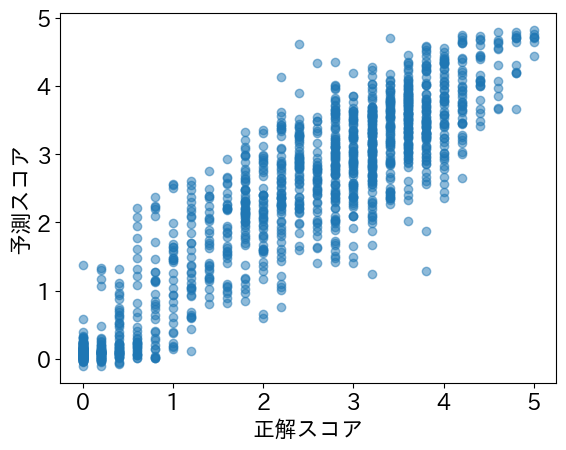

In [ ]:
import japanize_matplotlib
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16  # 文字サイズを設定

plt.scatter(
    [i["true_score"] for i in results],
    [i["pred_score"] for i in results],
    alpha=0.5
)
plt.xlabel("正解スコア")
plt.ylabel("予測スコア")
plt.show()

#### エラー分析

In [ ]:
# モデルの予測誤差が高い順にソート
sorted_results = sorted(
    results, key=lambda x: -abs(x["true_score"] - x["pred_score"])
)
# 高い確率で予測しながら誤った事例の上位を表示
for top_result in sorted_results[:5]:
    sentence1 = valid_dataset[top_result["example_id"]]["sentence1"]
    sentence2 = valid_dataset[top_result["example_id"]]["sentence2"]

    print(f"テキスト１：{sentence1}")
    print(f"テキスト２：{sentence2}")

    print(f"予測スコア：{top_result['pred_score']}")
    print(f"正解スコア：{top_result['true_score']}")
    # print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

テキスト１：建物の中で一頭の牛が人に引かれて立っています。
テキスト２：会場内で男性がホルスタインを連れています
予測スコア：1.2813432216644287
正解スコア：3.799999952316284
----------------
テキスト１：ジャンボジェット機が建物の上を低空飛行しています。
テキスト２：ジャンボジェット機が建物の上を高空飛行しています。
予測スコア：4.614662170410156
正解スコア：2.4000000953674316
----------------
テキスト１：ゲレンデのこぶでスキージャンプしています。
テキスト２：雪上でモーグルを楽しむ水色のウェアを着た女性。
予測スコア：1.2380545139312744
正解スコア：3.200000047683716
----------------
テキスト１：猫がぬいぐるみを抱いて寝ています。
テキスト２：ぬいぐるみの横で黒猫が寝ています。
予測スコア：4.13502311706543
正解スコア：2.200000047683716
----------------
テキスト１：真っ白なトイレと洗面台が備え付けられたバスルームの写真です。
テキスト２：全体を白に基調にしたユニットバスの写真です。
予測スコア：1.8714594841003418
正解スコア：3.799999952316284
----------------
